1. Loading CSV...
CSV contains 288 unique images.
2. Scanning folders in /data/ephemeral/home/data/test/DCM...
Found 288 matches. Visualizing 4 random samples...
Processing: image1664154558481.png (at ID272)


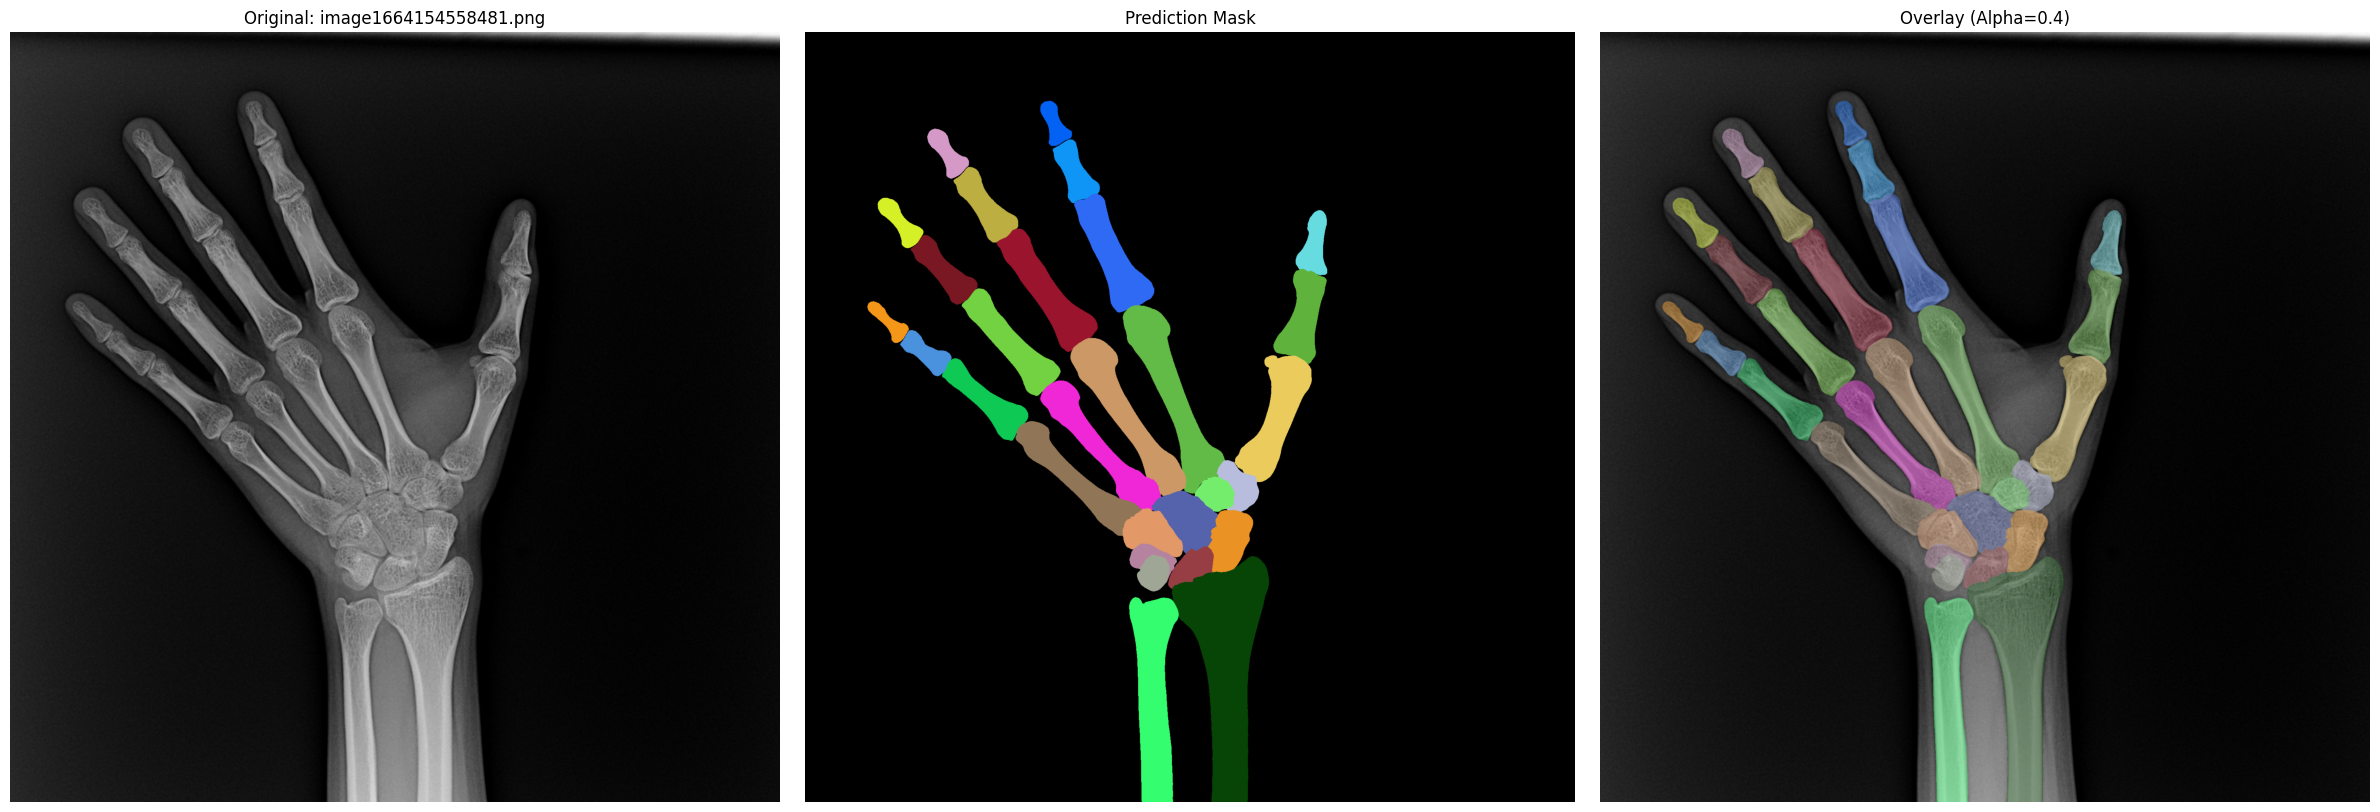

Processing: image1663636167346.png (at ID230)


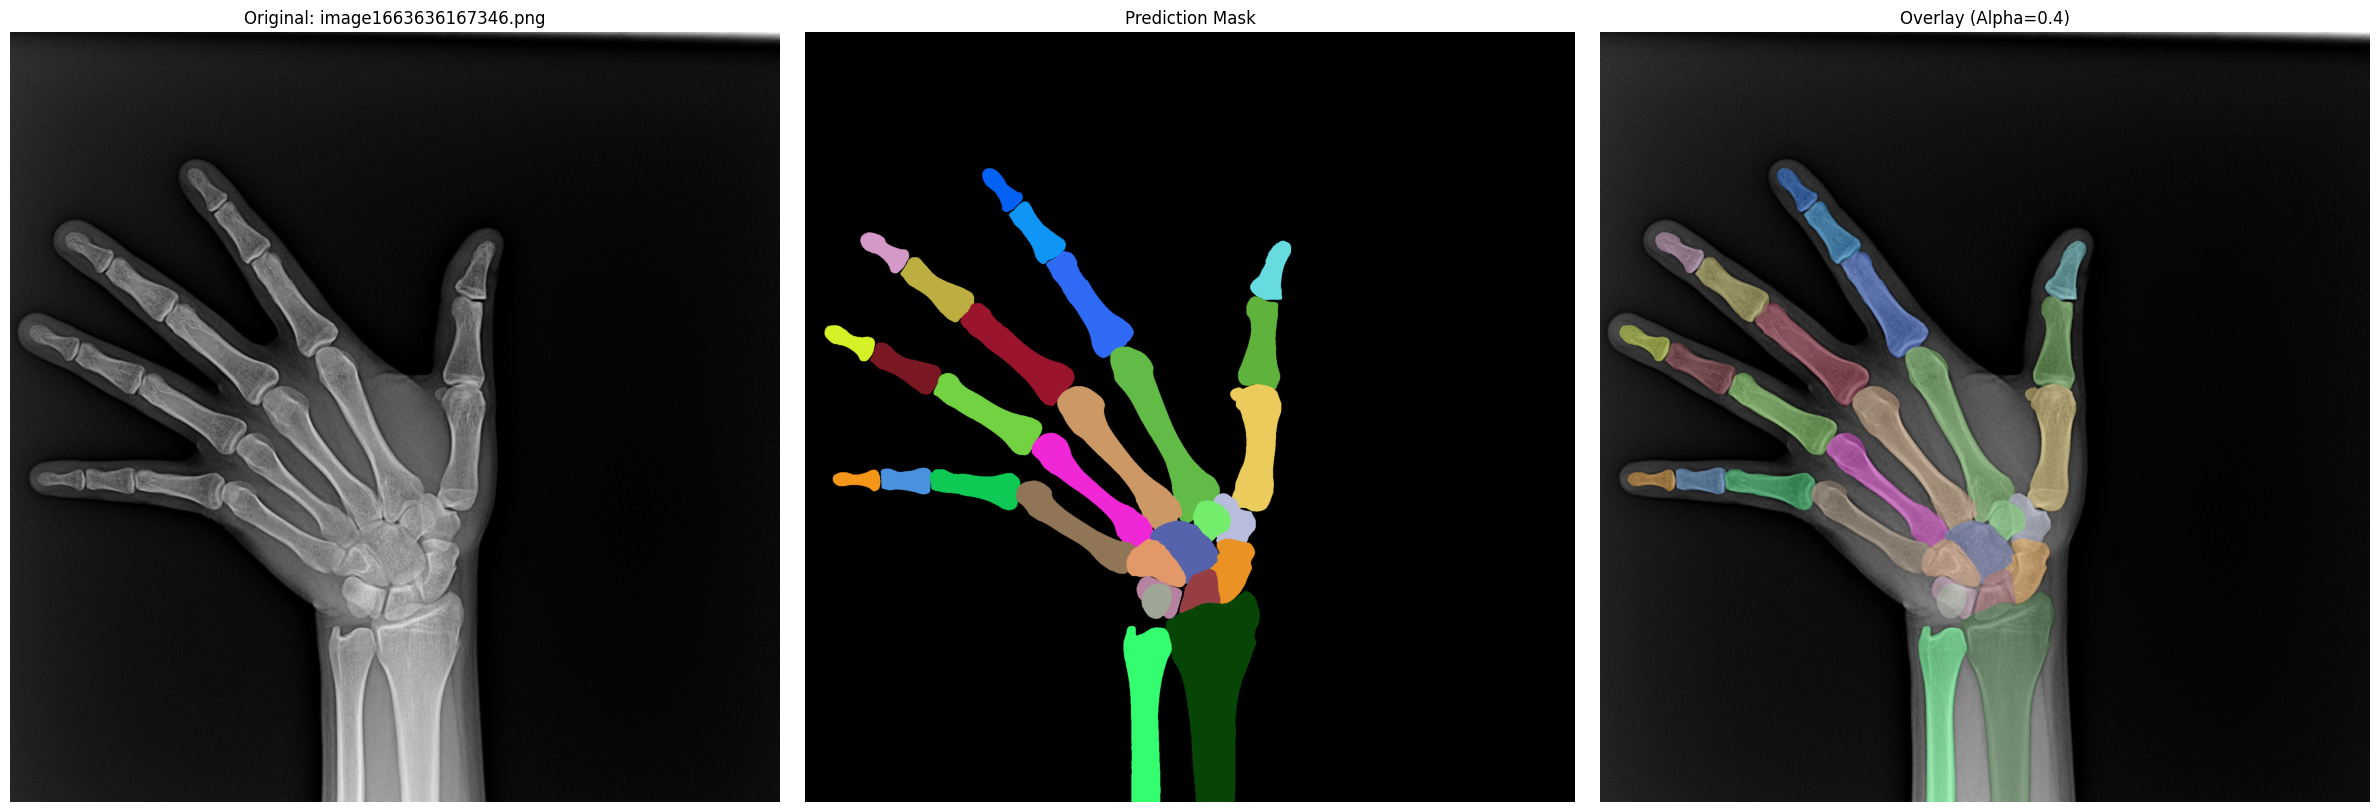

Processing: image1663031512045.png (at ID186)


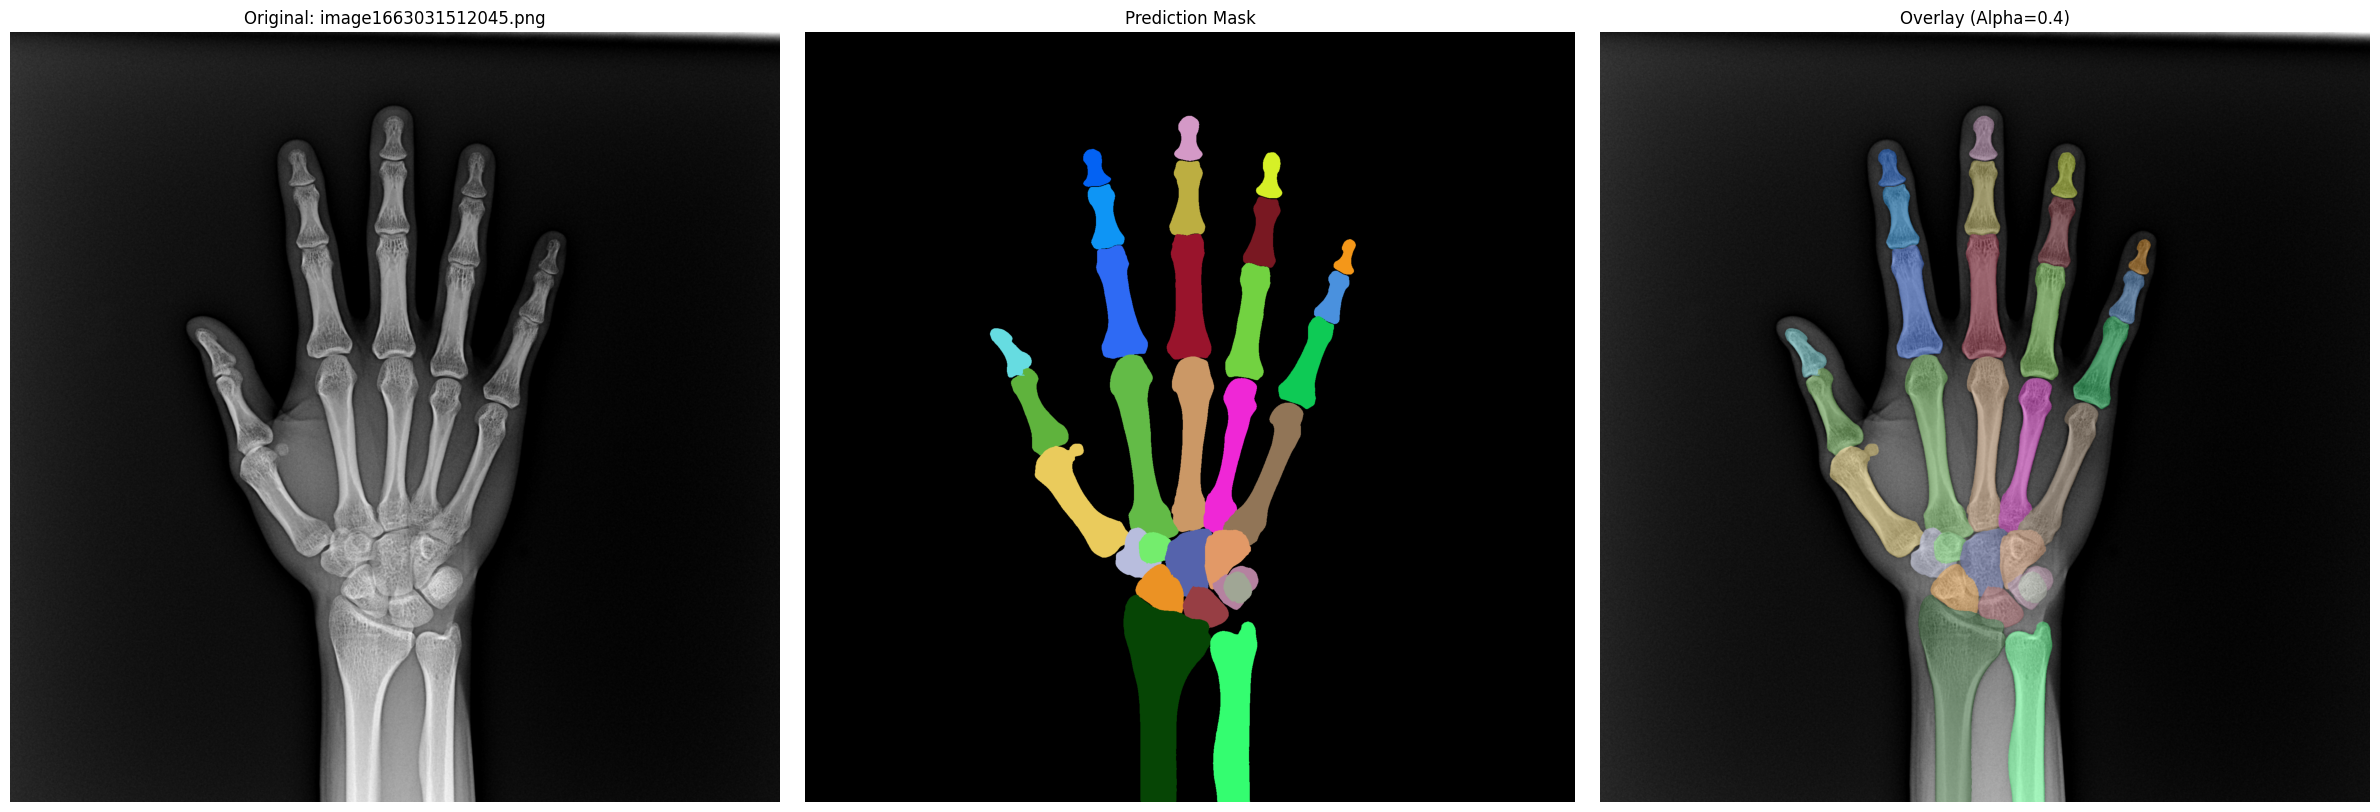

Processing: image1663721789852.png (at ID243)


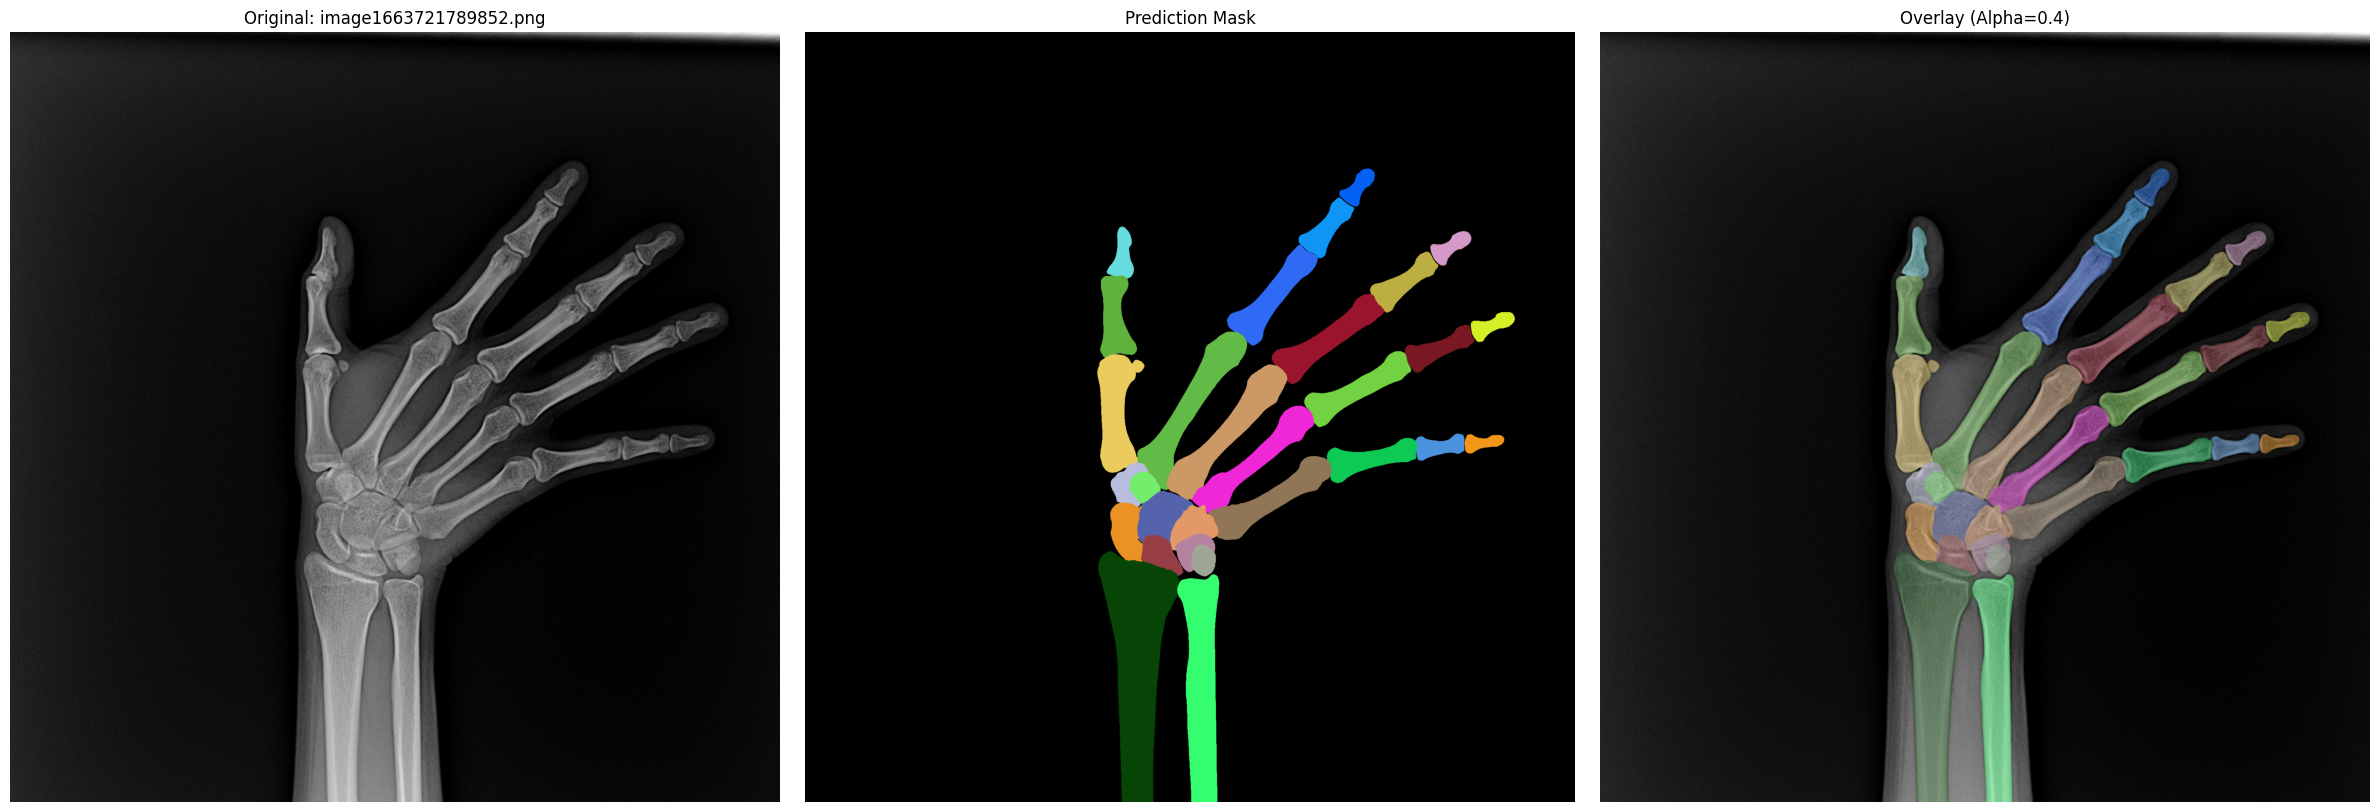

In [30]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# ==========================================
# 1. 설정
# ==========================================
IMAGE_ROOT = "/data/ephemeral/home/data/test/DCM"  
CSV_PATH = "9752.csv" 

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(CLASSES), 3), dtype="uint8")

# ==========================================
# 2. 유틸리티 함수
# ==========================================
def rle_decode(mask_rle, shape):
    if pd.isna(mask_rle) or mask_rle == '': 
        return np.zeros(shape, dtype=np.uint8)
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    return img.reshape(shape)

def label2rgb(mask_stack):
    h, w = mask_stack.shape[1], mask_stack.shape[2]
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    
    for i, mask in enumerate(mask_stack):
        idx = np.where(mask > 0)
        rgb[idx] = COLORS[i]
        
    return rgb

# ==========================================
# 3. 시각화 실행 함수 (핵심 수정됨)
# ==========================================
def visualize_target(full_path, filename_only, df):
    """
    full_path: 이미지를 로드하기 위한 절대 경로
    filename_only: CSV 검색을 위한 파일명
    """
    
    # 1. 이미지 로드
    if not os.path.exists(full_path):
        print(f"이미지 파일 없음: {full_path}")
        return

    image = cv2.imread(full_path)
    if image is None:
        print(f"이미지 로드 실패: {full_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 2. CSV 매칭
    img_df = df[df['image_name'] == filename_only]
    
    if len(img_df) == 0:
        print(f"CSV에서 {filename_only} 데이터를 찾지 못했습니다.")
        return

    # 3. 마스크 복원
    preds = []
    for class_name in CLASSES:
        rle = img_df[img_df['class'] == class_name]['rle'].values
        if len(rle) > 0:
            mask = rle_decode(rle[0], (2048, 2048))
        else:
            mask = np.zeros((2048, 2048), dtype=np.uint8)
        preds.append(mask)
    
    preds = np.stack(preds, axis=0)
    
    # 4. 오버레이 생성 (투명도 적용)
    rgb_mask = label2rgb(preds) # 컬러 마스크 (H, W, 3)
    
    # 이미지와 마스크 크기가 다를 경우 안전장치 (Resize)
    if image.shape[:2] != rgb_mask.shape[:2]:
        rgb_mask = cv2.resize(rgb_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 오버레이 만들기 (배경은 그대로 두고, 마스크 있는 부분만 섞기)
    overlay = image.copy()
    
    # 마스크가 존재하는 픽셀 찾기 (RGB 중 하나라도 0보다 크면 마스크임)
    mask_indices = np.any(rgb_mask > 0, axis=-1)
    
    # cv2.addWeighted 파라미터: (소스1, 가중치1, 소스2, 가중치2, 감마)
    # 이미지 60% + 마스크 40% 섞기
    alpha = 0.6 
    
    # 마스크가 있는 부분만 블렌딩 적용 (배경이 어두워지는 것 방지)
    if np.sum(mask_indices) > 0:
        overlay[mask_indices] = cv2.addWeighted(
            image[mask_indices], alpha, 
            rgb_mask[mask_indices], 1 - alpha, 
            0
        ).squeeze()

    # 5. 시각화 (3단 구성: 원본 | 마스크 | 오버레이)
    fig, ax = plt.subplots(1, 3, figsize=(24, 8))
    
    # (1) 원본
    ax[0].imshow(image)
    ax[0].set_title(f"Original: {filename_only}")
    ax[0].axis('off')
    
    # (2) 컬러 마스크 (배경 검정)
    ax[1].imshow(rgb_mask)
    ax[1].set_title("Prediction Mask")
    ax[1].axis('off')
    
    # (3) 오버레이 (원본 + 마스크)
    ax[2].imshow(overlay)
    ax[2].set_title("Overlay (Alpha=0.4)")
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 4. 메인 실행 코드
# ==========================================

print("1. Loading CSV...")
result_df = pd.read_csv(CSV_PATH)

target_filenames_set = set(result_df['image_name'].unique())
print(f"CSV contains {len(target_filenames_set)} unique images.")

print(f"2. Scanning folders in {IMAGE_ROOT}...")
valid_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff')
matched_files = [] 

for root, dirs, files in os.walk(IMAGE_ROOT):
    for file in files:
        if file.lower().endswith(valid_extensions):
            if file in target_filenames_set:
                full_path = os.path.join(root, file)
                matched_files.append((full_path, file))

if len(matched_files) == 0:
    print("CSV에 있는 파일명과 일치하는 이미지를 폴더에서 찾을 수 없습니다.")
else:
    # 랜덤 4개 선택
    sample_count = min(4, len(matched_files))
    sample_pairs = random.sample(matched_files, sample_count)

    print(f"Found {len(matched_files)} matches. Visualizing {sample_count} random samples...")

    for full_path, filename_only in sample_pairs:
        print(f"Processing: {filename_only} (at {os.path.basename(os.path.dirname(full_path))})")
        visualize_target(full_path, filename_only, result_df)